/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_83852/2209455413.py:24: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type="drive")


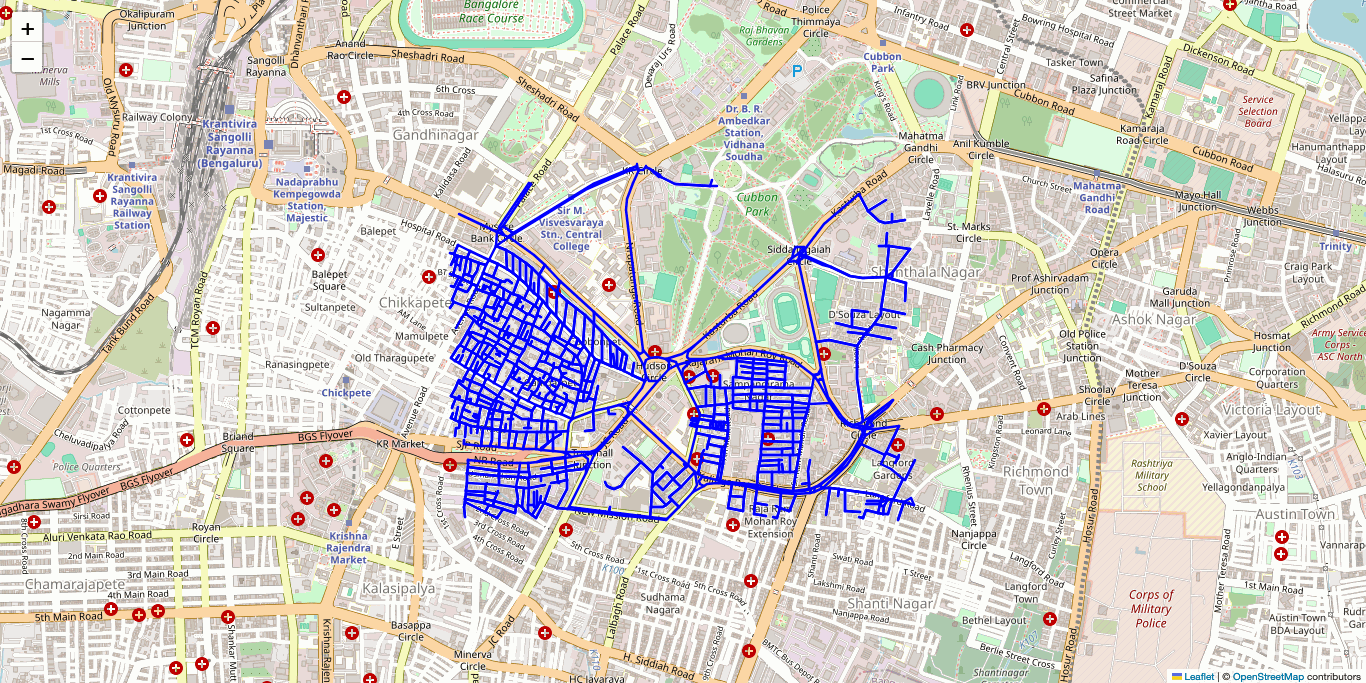

Simulation complete. Check the notebook for the Bangalore traffic congestion animation.


In [6]:
import io
import os

import folium
import networkx as nx
import osmnx as ox
from IPython.display import Image as IPImage
from IPython.display import display
from PIL import Image


from model import TrafficModel

# Bounding box coordinates for Bangalore
north, south, east, west = (
    12.976,
    12.961,
    77.599,
    77.579,
)  # Adjusted coordinates for Bangalore

# Create a graph from the bounding box using the bbox parameter
bbox = (north, south, east, west)
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")

# Extract graph bounds
min_x = min(nx.get_node_attributes(G, "x").values())
max_x = max(nx.get_node_attributes(G, "x").values())
min_y = min(nx.get_node_attributes(G, "y").values())
max_y = max(nx.get_node_attributes(G, "y").values())

# Running the modified TrafficModel
num_vehicles = 51
model = TrafficModel(G, num_vehicles, min_x, min_y, max_x, max_y)

# Ensure the directory exists
gif_dir = "Data/"
os.makedirs(gif_dir, exist_ok=True)

# Running the simulation and updating the Folium map
map_images = []
for _ in range(10):  # Run for 10 steps
    model.step()

    # Create a new map for each step
    temp_map = folium.Map(
        location=[(north + south) / 2, (east + west) / 2], zoom_start=15
    )

    # Add the road network to the map
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
    for _, row in edges.iterrows():
        points = [
            (row["geometry"].coords[i][1], row["geometry"].coords[i][0])
            for i in range(len(row["geometry"].coords))
        ]
        folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(temp_map)

    # Add vehicles to the map
    for vehicle in model.schedule.agents:
        if isinstance(vehicle, VehicleAgent):
            vehicle_position = (
                vehicle.model.space.G.nodes[vehicle.route[vehicle.current_step - 1]][
                    "y"
                ],
                vehicle.model.space.G.nodes[vehicle.route[vehicle.current_step - 1]][
                    "x"
                ],
            )
            color = (
                "red"
                if vehicle.vehicle_type == "car"
                else "blue"
                if vehicle.vehicle_type == "truck"
                else "green"
            )
            folium.CircleMarker(
                location=vehicle_position, radius=5, color=color, fill=True
            ).add_to(temp_map)

    # Save the map state as an image
    img_data = temp_map._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    map_images.append(img)

# Create an animated GIF from the saved map images
gif_path = os.path.join(gif_dir, "bangalore_traffic_congestion.gif")
map_images[0].save(
    gif_path, save_all=True, append_images=map_images[1:], duration=500, loop=0
)

# Display the animated GIF in the notebook
display(IPImage(filename=gif_path))

print(
    "Simulation complete. Check the notebook for the Bangalore traffic congestion animation."
)


In [5]:
import ipyreact
import pathlib
import numpy as np
import solara
import os
import osmnx as ox
import networkx as nx
import folium
import io
from PIL import Image
from model import TrafficModel, VehicleAgent

# Function to generate random vehicle positions as points
def generate(seed, N):
    np.random.seed(seed)
    mean = [0, 0]  # Mean of the distribution
    cov = [[1, 0], [0, 1]]  # Covariance matrix (identity matrix for simplicity)
    return np.random.multivariate_normal(mean, cov, N)

# Widget class for Voronoi visualization
class VoronoiWidget(ipyreact.ValueWidget):
    _esm = pathlib.Path("voronoi.tsx")

# Reactive states
render_voronoi = solara.reactive(True)
render_delaunay = solara.reactive(True)
seed = solara.reactive(42)
points = solara.reactive(20)

# Initialize the graph `G`
# For example, using the graph of Times Square, NYC
location_point = (40.7580, -73.9855)  # Times Square, NYC
G = ox.graph_from_point(location_point, dist=500, network_type='drive')

# Define the number of vehicles
num_vehicles = 10

# Extract the boundaries (min_x, min_y, max_x, max_y) from the graph `G`
x_values = [data['x'] for node, data in G.nodes(data=True)]
y_values = [data['y'] for node, data in G.nodes(data=True)]
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Function to clamp positions within bounds
def clamp_position(pos, min_val, max_val):
    return max(min(pos, max_val), min_val)

# Function to retrieve vehicle positions from the TrafficModel
def get_vehicle_positions(model):
    positions = []
    for vehicle in model.schedule.agents:
        if isinstance(vehicle, VehicleAgent):
            vehicle_position = (
                clamp_position(vehicle.model.space.G.nodes[vehicle.route[vehicle.current_step - 1]]['x'], min_x, max_x),
                clamp_position(vehicle.model.space.G.nodes[vehicle.route[vehicle.current_step - 1]]['y'], min_y, max_y)
            )
            positions.append(vehicle_position)
    return np.array(positions)

# Voronoi visualization component
@solara.component
def VoronoiPage():
    model = TrafficModel(G, num_vehicles, min_x, min_y, max_x, max_y)  # Traffic model instance
    
    data = solara.use_memo(lambda: get_vehicle_positions(model), [model.schedule.agents])

    with solara.Column():
        with solara.Row():
            solara.Switch(label="Render delaunay", value=render_delaunay)
            solara.Switch(label="Render voronoi", value=render_voronoi)
        solara.SliderInt(label="points", value=points, min=10, max=500)
    
    VoronoiWidget.element(
        value=data.tolist(),
        props={"width": 600, "height": 400, "render_delaunay": render_delaunay.value, "render_voronoi": render_voronoi.value},
    )

# Running the Voronoi visualization page
VoronoiPage()


Cannot show ipywidgets in text

In [6]:
import folium
import osmnx as ox
import networkx as nx
import numpy as np
from model import TrafficModel, VehicleAgent
from folium.plugins import MarkerCluster

# Define location (e.g., Times Square, NYC)
location_point = (40.7580, -73.9855)
G = ox.graph_from_point(location_point, dist=500, network_type='drive')

# Extract the boundaries (min_x, min_y, max_x, max_y) from the graph `G`
x_values = [data['x'] for node, data in G.nodes(data=True)]
y_values = [data['y'] for node, data in G.nodes(data=True)]
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Number of vehicles
num_vehicles = 10

# Function to create the Folium map
def create_folium_map(G, vehicles_positions, location=location_point):
    # Initialize Folium map
    m = folium.Map(location=location, zoom_start=15)

    # Plot road network
    ox.plot_graph_folium(G, graph_map=m, popup_attribute='name', edge_width=2)

    # Add vehicle positions to the map
    marker_cluster = MarkerCluster().add_to(m)
    for pos in vehicles_positions:
        folium.Marker(location=[pos[1], pos[0]]).add_to(marker_cluster)
    
    return m

# Function to get vehicle positions from the TrafficModel
def get_vehicle_positions(model):
    positions = []
    for vehicle in model.schedule.agents:
        if isinstance(vehicle, VehicleAgent):
            vehicle_position = (
                model.space.G.nodes[vehicle.route[vehicle.current_step - 1]]['x'],
                model.space.G.nodes[vehicle.route[vehicle.current_step - 1]]['y']
            )
            positions.append(vehicle_position)
    return positions

# Voronoi visualization component
def VoronoiPage():
    # Initialize the traffic model
    model = TrafficModel(G, num_vehicles, min_x, min_y, max_x, max_y)
    
    # Get vehicle positions
    vehicle_positions = get_vehicle_positions(model)

    # Create Folium map with vehicle positions
    folium_map = create_folium_map(G, vehicle_positions)

    # Display the Folium map
    return folium_map._repr_html_()

# Display the Voronoi page with map visualization
VoronoiPage()


/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_88943/2666912166.py:27: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_graph_folium(G, graph_map=m, popup_attribute='name', edge_width=2)


'<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe srcdoc="&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&gt;\n    \n    &lt;meta http-equiv=&quot;content-type&quot; content=&quot;text/html; charset=UTF-8&quot; /&gt;\n    \n        &lt;script&gt;\n            L_NO_TOUCH = false;\n            L_DISABLE_3D = false;\n        &lt;/script&gt;\n    \n    &lt;style&gt;html, body {width: 100%;height: 100%;margin: 0;padding: 0;}&lt;/style&gt;\n    &lt;style&gt;#map {position:absolute;top:0;bottom:0;right:0;left:0;}&lt;/style&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://code.jquery.com/jquery-3.7.1.min.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js&quot;&gt;&lt;/sc